In [363]:
suppressPackageStartupMessages(library(readxl))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(pheatmap))
suppressPackageStartupMessages(library(stringr))
library(hise)
library(plyr)
library(purrr)
library(vegan)
#library(arrow)
library(rstatix)
library(parallel)
library(ggpubr)
library(ComplexHeatmap)
library(compositions)
library(ggsci)
library(ggpubr)

ERROR: Error in library(compositions): there is no package called ‘compositions’


In [60]:
colors = c('#FDC086','#FFFF99','#F0027F','#BF5B17','#666666',
          '#1B9E77','#D95F02','#7570B3','#E7298A','#66A61E','#E6AB02','#A6761D','#666666',
          '#A6CEE3','#1F78B4','#B2DF8A','#33A02C','#FB9A99','#E31A1C','#FDBF6F','#FF7F00',
          '#CAB2D6','#6A3D9A','#FFFF99','#B15928','#FBB4AE','#B3CDE3','#CCEBC5','#DECBE4',
          '#FED9A6','#FFFFCC','#E5D8BD','#FDDAEC','#F2F2F2','#B3E2CD','#FDCDAC','#CBD5E8',
          '#F4CAE4','#E6F5C9','#FFF2AE','#F1E2CC','#CCCCCC','#E41A1C','#377EB8','#4DAF4A',
          '#984EA3','#FF7F00','#FFFF33','#A65628','#F781BF','#999999','#66C2A5','#FC8D62',
          '#8DA0CB','#E78AC3','#A6D854','#FFD92F','#E5C494','#B3B3B3','#8DD3C7','#FFFFB3',
          '#BEBADA','#FB8072','#80B1D3','#FDB462','#B3DE69','#FCCDE5','#D9D9D9','#BC80BD',
          '#CCEBC5','#FFED6F')


# Reading the file

In [17]:
# Read the CSV file into a data frame
all_df <- read.csv('/home/jupyter/Myeloid_cells/files/Parquet_files/AIFI_Reference_processed.csv')


In [18]:
#remove UPI from the cohort
all_df <- all_df %>% filter(cohort.cohortGuid != 'UP1')

In [ ]:
#colnames(myeloid_df)

In [20]:
rownames(all_df)<-all_df$cell_uuid

# CLR Transform


In [21]:
clr_transform <- function(x) {
  if (length(x) == 0) {
    return(NA)  # return NA for empty vectors
  }
  geom_mean <- exp(mean(log(x)))
  return(log(x / geom_mean))
}

In [19]:
#example code
columns = ['temperature','humidity' ,'pressure','rain' ,'lightavgw/o0','lightmax','moisture']
for col in columns:
    plt.figure()   # plots figure for each iteration
    plt.boxplot(df[col])

# Comparsion within total PBMCs (Percentage and Percentage CLR)

In [221]:
## Percentage of total

result <- all_df %>%
  dplyr::group_by(AIFI_L3, subject.subjectGuid) %>%               
  dplyr::summarise(count = n()) %>%                  # Count occurrences
  dplyr::group_by(subject.subjectGuid) %>%                       
  dplyr::mutate(percentage = (count / sum(count)) * 100) %>% 
  dplyr::group_by(subject.subjectGuid) %>%     
  dplyr::mutate(percentage_clr = clr_transform((percentage))) %>% # Group again by subjectGuid for CLR# Calculate percentage
  dplyr::ungroup()

head(result)
#sum(result$subject.subjectGuid)

`summarise()` has grouped output by 'AIFI_L3'. You can override using the
`.groups` argument.


AIFI_L3,subject.subjectGuid,count,percentage,percentage_clr
<chr>,<chr>,<int>,<dbl>,<dbl>
ASDC,BR1001,6,0.03236770,-2.232976
ASDC,BR1002,5,0.02637409,-2.242500
ASDC,BR1003,4,0.02094680,-2.763896
ASDC,BR1004,3,0.01710571,-2.626914
ASDC,BR1005,5,0.02809620,-1.943233
ASDC,BR1006,4,0.02300966,-2.337902


In [222]:
result %>% filter(subject.subjectGuid == "BR1001") %>% 
      select(percentage) %>%
      pull() %>% 
      sum()

[1] 100

In [223]:
result<-left_join(result,unique(all_df[c('cohort.cohortGuid','subject.subjectGuid','subject.biologicalSex','CMV.IgG.Serology.Result.Interpretation')]),by=c('subject.subjectGuid'))

In [224]:
head(result)


AIFI_L3,subject.subjectGuid,count,percentage,percentage_clr,cohort.cohortGuid,subject.biologicalSex,CMV.IgG.Serology.Result.Interpretation
<chr>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>
ASDC,BR1001,6,0.03236770,-2.232976,BR1,Female,Negative
ASDC,BR1002,5,0.02637409,-2.242500,BR1,Male,Negative
ASDC,BR1003,4,0.02094680,-2.763896,BR1,Female,Negative
ASDC,BR1004,3,0.01710571,-2.626914,BR1,Male,Negative
ASDC,BR1005,5,0.02809620,-1.943233,BR1,Female,Negative
ASDC,BR1006,4,0.02300966,-2.337902,BR1,Male,Negative


In [158]:
table(result$AIFI_L3)


             Activated memory B cell                     Adaptive NK cell 
                                  77                                   92 
                                ASDC                         BaEoMaP cell 
                                  86                                   47 
                  C1Q+ CD16 monocyte                           CD14+ cDC2 
                                  92                                   92 
               CD27- effector B cell                CD27+ effector B cell 
                                  92                                   92 
                            CD4 MAIT                   CD56bright NK cell 
                                  91                                   92 
                            CD8 MAIT                                CD8aa 
                                  92                                   89 
                  CD95 memory B cell                                 cDC1 
                        

# Loop for comparing the four groups together - withing total PBMCs

In [ ]:
#result_cohort, aes(x = reorder(AIFI_L3, desc(percentage)) , y = percentage, color = cohort.cohortGuid)

In [225]:
# Create a new column by combining values from column1 and column2
result$facet_combined <- paste(result$cohort.cohortGuid, result$CMV.IgG.Serology.Result.Interpretation, sep = "_")
result$facet_combined<- factor(result$facet_combined)
# # Create the four groups
# BR1_Negative <- subset(result, cohort.cohortGuid == 'BR1' & CMV.IgG.Serology.Result.Interpretation == 'Negative')
# BR2_Negative <- subset(result, cohort.cohortGuid == 'BR2' & CMV.IgG.Serology.Result.Interpretation == 'Negative')
# BR1_Positive <- subset(result, cohort.cohortGuid == 'BR1' & CMV.IgG.Serology.Result.Interpretation == 'Positive')
# BR2_Positive <- subset(result, cohort.cohortGuid == 'BR2' & CMV.IgG.Serology.Result.Interpretation == 'Positive')

# #DF <- data.frame(BR1_Negative, BR2_Negative, BR1_Positive, BR2_Positive)

# # Combine the four data frames into a single data frame
# combined_df <- rbind(BR1_Negative, BR2_Negative, BR1_Positive, BR2_Positive)



In [226]:
head(result)

AIFI_L3,subject.subjectGuid,count,percentage,percentage_clr,cohort.cohortGuid,subject.biologicalSex,CMV.IgG.Serology.Result.Interpretation,facet_combined
<chr>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<fct>
ASDC,BR1001,6,0.03236770,-2.232976,BR1,Female,Negative,BR1_Negative
ASDC,BR1002,5,0.02637409,-2.242500,BR1,Male,Negative,BR1_Negative
ASDC,BR1003,4,0.02094680,-2.763896,BR1,Female,Negative,BR1_Negative
ASDC,BR1004,3,0.01710571,-2.626914,BR1,Male,Negative,BR1_Negative
ASDC,BR1005,5,0.02809620,-1.943233,BR1,Female,Negative,BR1_Negative
ASDC,BR1006,4,0.02300966,-2.337902,BR1,Male,Negative,BR1_Negative


In [302]:
B_df <- result %>% 
    filter(AIFI_L3 == 'ASDC')

In [303]:
head(B_df)

AIFI_L3,subject.subjectGuid,count,percentage,percentage_clr,cohort.cohortGuid,subject.biologicalSex,CMV.IgG.Serology.Result.Interpretation,facet_combined
<chr>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<fct>
ASDC,BR1001,6,0.03236770,-2.232976,BR1,Female,Negative,BR1_Negative
ASDC,BR1002,5,0.02637409,-2.242500,BR1,Male,Negative,BR1_Negative
ASDC,BR1003,4,0.02094680,-2.763896,BR1,Female,Negative,BR1_Negative
ASDC,BR1004,3,0.01710571,-2.626914,BR1,Male,Negative,BR1_Negative
ASDC,BR1005,5,0.02809620,-1.943233,BR1,Female,Negative,BR1_Negative
ASDC,BR1006,4,0.02300966,-2.337902,BR1,Male,Negative,BR1_Negative


In [150]:
head(BR1_Negative)

AIFI_L3,subject.subjectGuid,count,percentage,percentage_clr,cohort.cohortGuid,subject.biologicalSex,CMV.IgG.Serology.Result.Interpretation,facet_combined
<chr>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<fct>
ASDC,BR1001,6,0.03236770,-2.232976,BR1,Female,Negative,BR1.Negative
ASDC,BR1002,5,0.02637409,-2.242500,BR1,Male,Negative,BR1.Negative
ASDC,BR1003,4,0.02094680,-2.763896,BR1,Female,Negative,BR1.Negative
ASDC,BR1004,3,0.01710571,-2.626914,BR1,Male,Negative,BR1.Negative
ASDC,BR1005,5,0.02809620,-1.943233,BR1,Female,Negative,BR1.Negative
ASDC,BR1006,4,0.02300966,-2.337902,BR1,Male,Negative,BR1.Negative


In [148]:
stat_test<- combined_df %>%
  select(percentage, percentage_clr, AIFI_L3, cohort.cohortGuid, CMV.IgG.Serology.Result.Interpretation, facet_combined, subject.subjectGuid) %>%
  unique(.) %>%
  group_by(facet_combined, subject.subjectGuid) %>%
  wilcox_test(percentage ~ cohort.cohortGuid) #%>%
  adjust_pvalue(method = "BH") %>%
  add_significance()



ERROR: [1m[33mError[39m in `mutate()`:[22m
[1m[22m[36mℹ[39m In argument: `data = map(.data$data, .f, ...)`.
[1mCaused by error in `map()`:[22m
[1m[22m[36mℹ[39m In index: 1.
[1mCaused by error in `wilcox.test.default()`:[22m
[33m![39m not enough 'y' observations


In [80]:
unique(combined_df$facet_combined)


[1] BR1.Negative BR2.Negative BR1.Positive BR2.Positive
Levels: BR1.Negative BR2.Negative BR1.Positive BR2.Positive

In [283]:
#Doesn't p-adjust
# Visualize: Specify the comparisons you want
my_comparisons <- list(c("BR1.Negative", "BR2.Negative"), c("BR1.Negative", "BR1.Positive"), c("BR1.Positive", "BR2.Positive"), c("BR2.Negative", "BR2.Positive") )
p1 <- B_df %>%
    ggpubr::ggboxplot(x = 'facet_combined', y = 'percentage_clr', color = 'CMV.IgG.Serology.Result.Interpretation', add = "jitter", size = 1) +
    ylab('percentage_clr') + 
    xlab('AIFI_L3') +
    #scale_y_continuous(breaks = c(0.000, 0.025, 0.050, 0.075, 0.100)) +  # Set y-axis scale
    scale_color_manual(values = c("lightgreen", "red", "orange")) +
   stat_compare_means(comparisons = my_comparisons, method = "wilcox.test", paired = FALSE) + 
    stat_compare_means(label.y = 0.02)+
     theme(axis.text.x = element_text(size = 12),     # Adjust font size of x-axis text
        axis.text.y = element_text(size = 12),     # Adjust font size of y-axis text
        axis.title = element_text(size = 14))



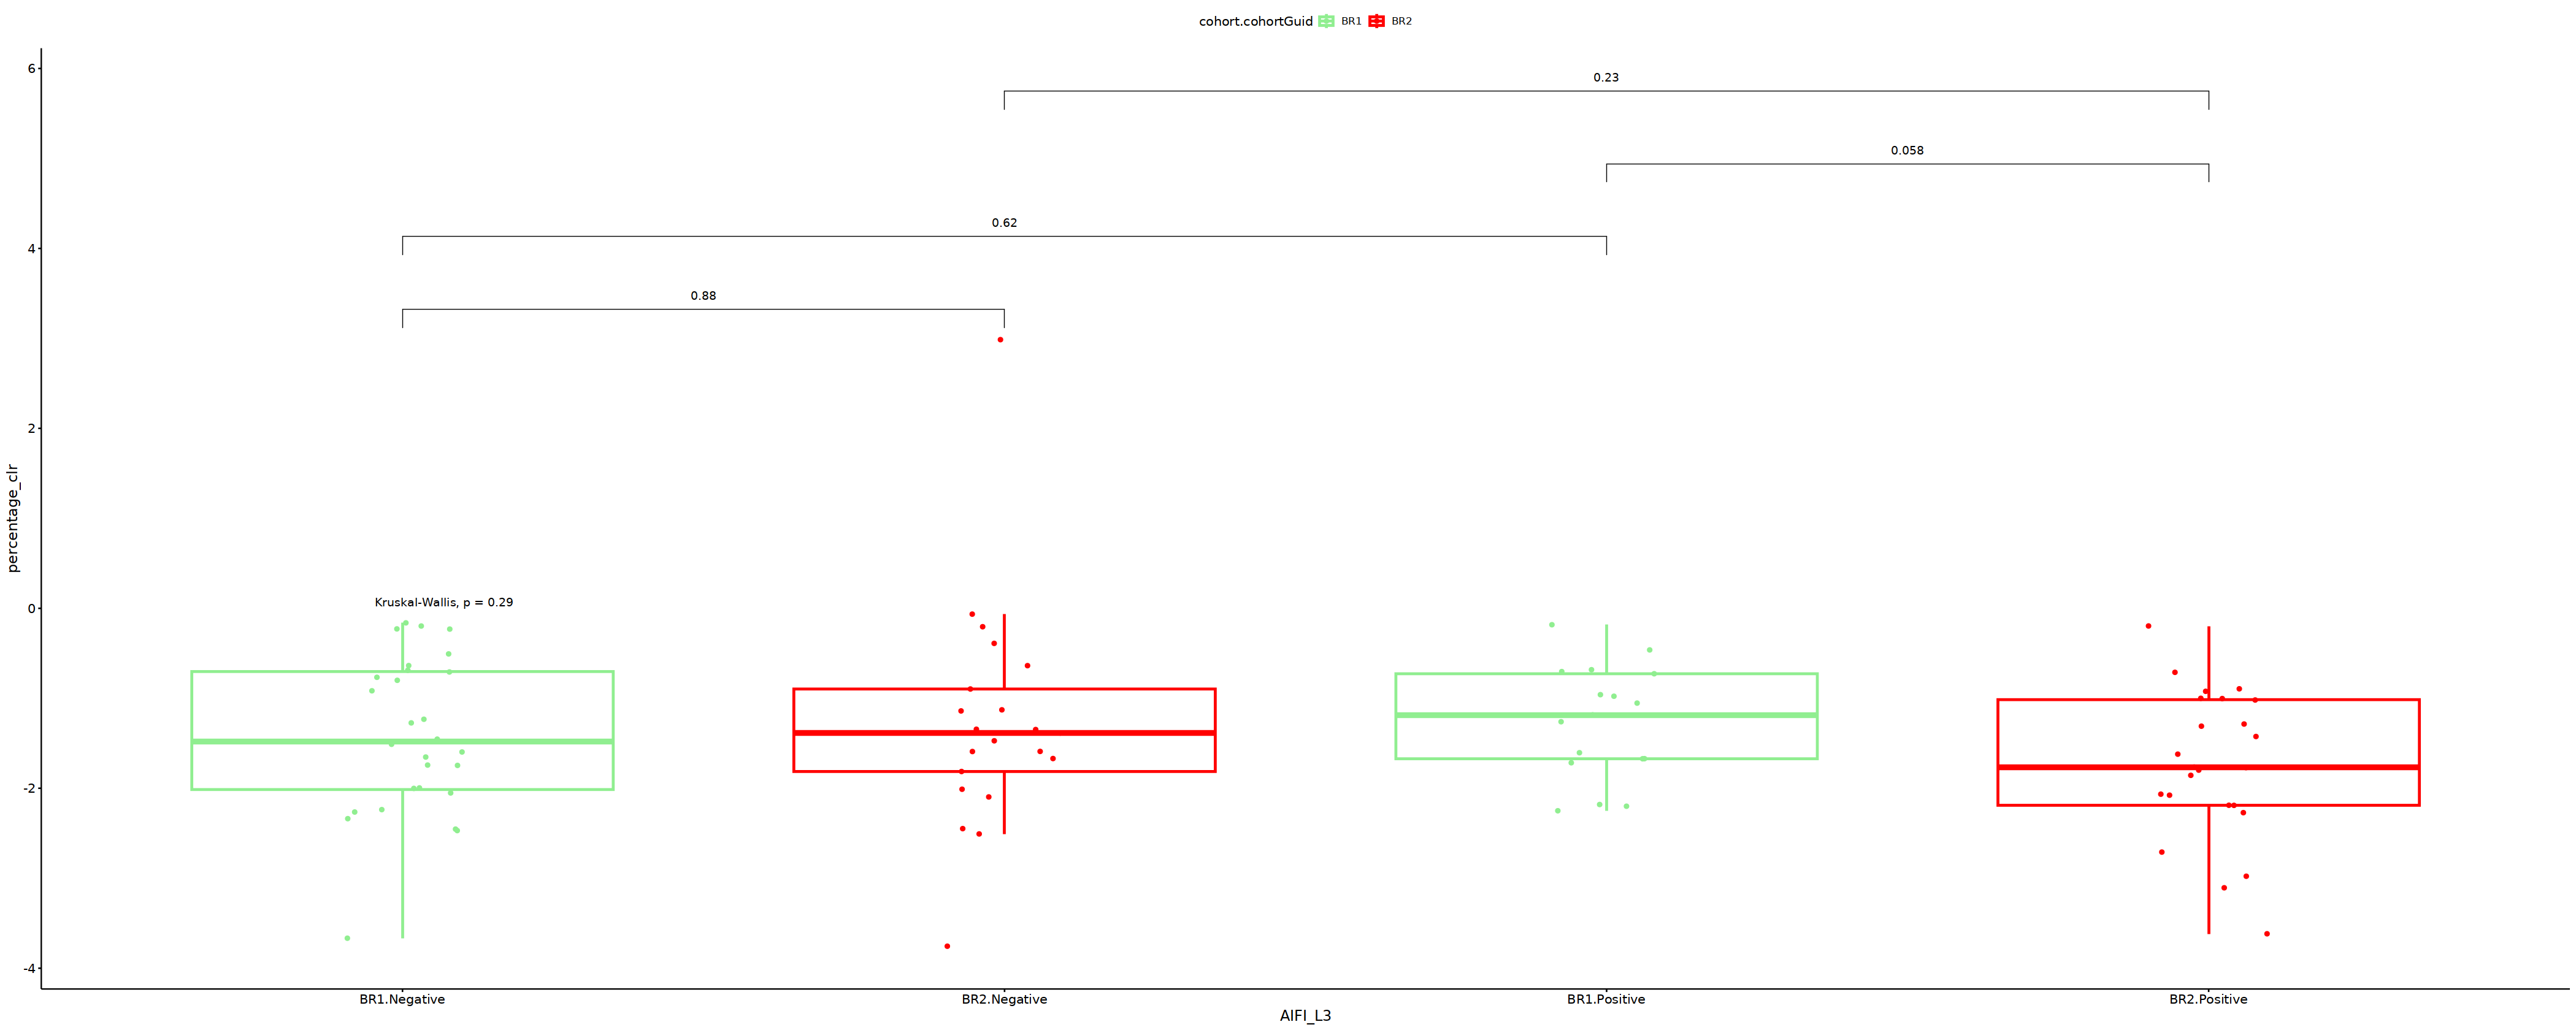

In [105]:
p1

In [162]:
# Visualize: Specify the comparisons you want
my_comparisons <- list(c("BR1.Negative", "BR2.Negative"), c("BR1.Negative", "BR1.Positive"), c("BR1.Positive", "BR2.Positive"), c("BR2.Negative", "BR2.Positive") )
t_test_tooth <- compare_means(percentage_clr ~ facet_combined , comparisons = my_comparisons, p.adjust.method = "BH", method='wilcox.test', data = B_df, paired = FALSE)
t_test_tooth <- t_test_tooth %>% mutate(y.position = c(5, 5.5, 6, 6.5, 7, 7.5))

result <- wilcox_test(percentage_clr ~ facet_combined, data = B_df, comparisons = my_comparisons, paired= FALSE)%>% 
   adjust_pvalue(method = 'BH')

In [163]:
head(result)

.y.,group1,group2,n1,n2,statistic,p,p.adj,p.adj.signif
<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>
percentage_clr,BR1.Negative,BR2.Negative,28,21,286,0.881,0.881,ns
percentage_clr,BR1.Negative,BR1.Positive,28,17,216,0.618,0.824,ns
percentage_clr,BR1.Positive,BR2.Positive,17,24,276,0.058,0.232,ns
percentage_clr,BR2.Negative,BR2.Positive,21,24,306,0.226,0.452,ns


In [145]:
head(t_test_tooth)

.y.,group1,group2,p,p.adj,p.format,p.signif,method,y.position
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
percentage_clr,BR1.Negative,BR2.Negative,0.88069376,0.88,0.881,ns,Wilcoxon,5.0
percentage_clr,BR1.Negative,BR1.Positive,0.61830306,0.88,0.618,ns,Wilcoxon,5.5
percentage_clr,BR1.Negative,BR2.Positive,0.15607635,0.45,0.156,ns,Wilcoxon,6.0
percentage_clr,BR2.Negative,BR1.Positive,0.77173409,0.88,0.772,ns,Wilcoxon,6.5
percentage_clr,BR2.Negative,BR2.Positive,0.22597573,0.45,0.226,ns,Wilcoxon,7.0
percentage_clr,BR1.Positive,BR2.Positive,0.05788685,0.35,0.058,ns,Wilcoxon,7.5


In [326]:
####### THIS USES GGPUBR - ggboxplot


#my_comparisons <- list(c("BR1.Negative", "BR2.Negative"), c("BR1.Negative", "BR1.Positive"), c("BR1.Positive", "BR2.Positive"), c("BR2.Negative", "BR2.Positive") )
#my_comparisons <- list(c("Negative", "Positive"), c("BR1.Negative", "BR1.Positive"), c("BR1.Positive", "BR2.Positive"), c("BR2.Negative", "BR2.Positive") )
#comparisons = my_comparisons
my_comparisons <- list(c("BR1_Negative", "BR2_Negative"), c("BR1_Negative", "BR1_Positive"), c("BR1_Positive", "BR2_Positive"), c("BR2_Negative", "BR2_Positive") )

stat_test <- wilcox_test(percentage ~ facet_combined, data = B_df, comparisons = my_comparisons, paired= FALSE)%>% 
   adjust_pvalue(method = 'BH') %>% 
   add_xy_position(x = "facet_combined", dodge = 0.8)

options(repr.plot.width = 12, repr.plot.height = 10)
p2 <- B_df %>%
    ggpubr::ggboxplot(x = 'facet_combined', y = 'percentage', color = 'CMV.IgG.Serology.Result.Interpretation', add = "jitter", size = 1) +
    ylab('percentage') + 
    xlab('AIFI_L3') +
    scale_color_manual(values = c("green", "red", "orange", "blue")) +
     theme(axis.text.x = element_text(size = 12, angle = 90 ),     # Adjust font size of x-axis text
        axis.text.y = element_text(size = 12),     # Adjust font size of y-axis text
        axis.title = element_text(size = 14))+
    stat_pvalue_manual(stat_test, label = "p.adj", tip.lenght =0)+   #, y.position = c(5, 5.5, 6 ,6.5))
    scale_y_continuous(expand = expansion(mult = c(0, 0.1)))



In [359]:
####### THIS USES GGPLOT2


#my_comparisons <- list(c("BR1.Negative", "BR2.Negative"), c("BR1.Negative", "BR1.Positive"), c("BR1.Positive", "BR2.Positive"), c("BR2.Negative", "BR2.Positive") )
#my_comparisons <- list(c("Negative", "Positive"), c("BR1.Negative", "BR1.Positive"), c("BR1.Positive", "BR2.Positive"), c("BR2.Negative", "BR2.Positive") )
#comparisons = my_comparisons
my_comparisons <- list(c("BR1_Negative", "BR2_Negative"), c("BR1_Negative", "BR1_Positive"), c("BR1_Positive", "BR2_Positive"), c("BR2_Negative", "BR2_Positive") )

stat_test <- wilcox_test(percentage ~ facet_combined, data = B_df, comparisons = my_comparisons, paired= FALSE)%>% 
   adjust_pvalue(method = 'BH') %>% 
   add_xy_position(x = "facet_combined", dodge = 0.8)

outfile <- paste("/home/jupyter/Myeloid_cells/Plots/Percentage_Comparisons_cohort_&_CMV/Percentage_Comparisons_cohort_&_CMV_", 'test', ".pdf", sep="")
options(repr.plot.width = 18, repr.plot.height = 10)
p3 <- ggplot(B_df, aes(x = facet_combined, y = percentage, color = CMV.IgG.Serology.Result.Interpretation)) +
  geom_boxplot(width = 0.5) +
  geom_jitter(width =0.1) +
  ylab('percentage') + 
  xlab('AIFI_L3') +
  scale_color_manual(values = c("green", "red", "orange", "blue")) +
  theme(axis.text.x = element_text(size = 12, angle = 90 ),     # Adjust font size of x-axis text
        axis.text.y = element_text(size = 12),     # Adjust font size of y-axis text
        axis.title = element_text(size = 14),
        panel.background = element_rect(fill = "white"),
        axis.line = element_line(color = "black"),  # Set axis line color to black,  # Set major grid line color to black
        panel.grid.minor = element_blank(),
        legend.position = "top",  # Set legend position to top
        #legend.title = element_blank()
       ) +
  geom_boxplot(position = position_dodge(width = 1))+
  stat_pvalue_manual(stat_test, label = "p.adj.signif", tip.length = 0) +
  scale_y_continuous(expand = expansion(mult = c(0, 0.1)))
  pdf(file = outfile, width = 7, height = 11)
    print(p3)
    dev.off()



png 
  2

.y.        group1       group2       n1 n2 statistic p     p.adj p.adj.signif
1 percentage BR1_Negative BR2_Negative 28 19 280       0.772 0.944 ns          
2 percentage BR1_Negative BR1_Positive 28 17 215       0.602 0.944 ns          
3 percentage BR1_Positive BR2_Positive 17 22 184       0.944 0.944 ns          
4 percentage BR2_Negative BR2_Positive 19 22 189       0.614 0.944 ns          
  y.position groups       <NA>         <NA>         <NA>         xmin xmax
1 0.06888    BR1_Negative BR1_Negative BR1_Positive BR2_Negative 1    3   
2 0.07272    BR2_Negative BR1_Positive BR2_Positive BR2_Positive 1    2   
3 0.07656    BR1_Negative BR1_Negative BR1_Positive BR2_Negative 2    4   
4 0.08040    BR2_Negative BR1_Positive BR2_Positive BR2_Positive 3    4

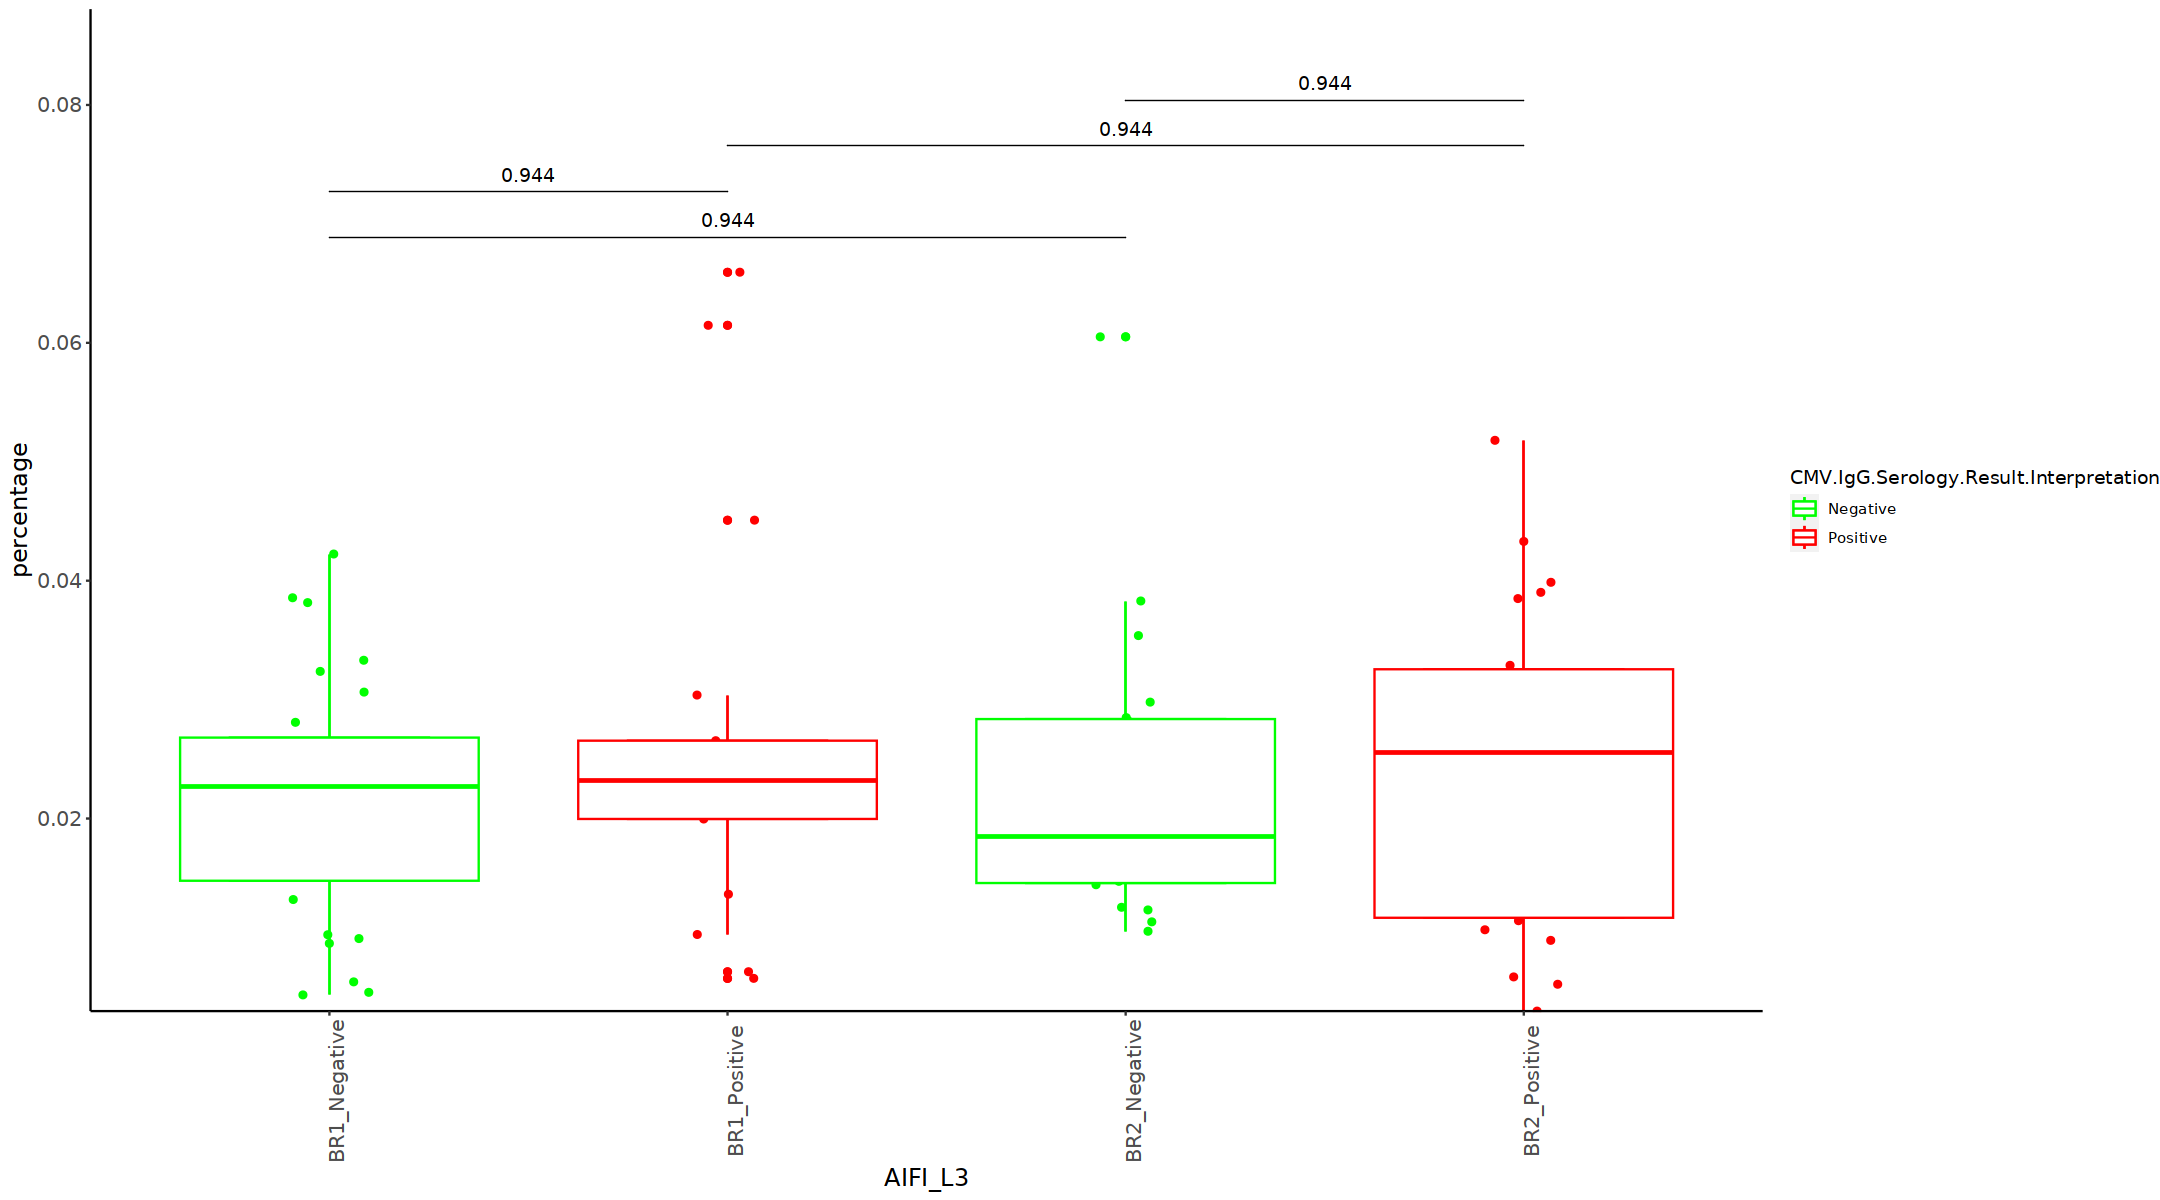

In [355]:
p3
stat_test

.y.        group1       group2       n1 n2 statistic p     p.adj p.adj.signif
1 percentage BR1_Negative BR2_Negative 28 19 280       0.772 0.944 ns          
2 percentage BR1_Negative BR1_Positive 28 17 215       0.602 0.944 ns          
3 percentage BR1_Positive BR2_Positive 17 22 184       0.944 0.944 ns          
4 percentage BR2_Negative BR2_Positive 19 22 189       0.614 0.944 ns          
  y.position groups       <NA>         <NA>         <NA>         xmin xmax
1 0.06888    BR1_Negative BR1_Negative BR1_Positive BR2_Negative 1    3   
2 0.07272    BR2_Negative BR1_Positive BR2_Positive BR2_Positive 1    2   
3 0.07656    BR1_Negative BR1_Negative BR1_Positive BR2_Negative 2    4   
4 0.08040    BR2_Negative BR1_Positive BR2_Positive BR2_Positive 3    4

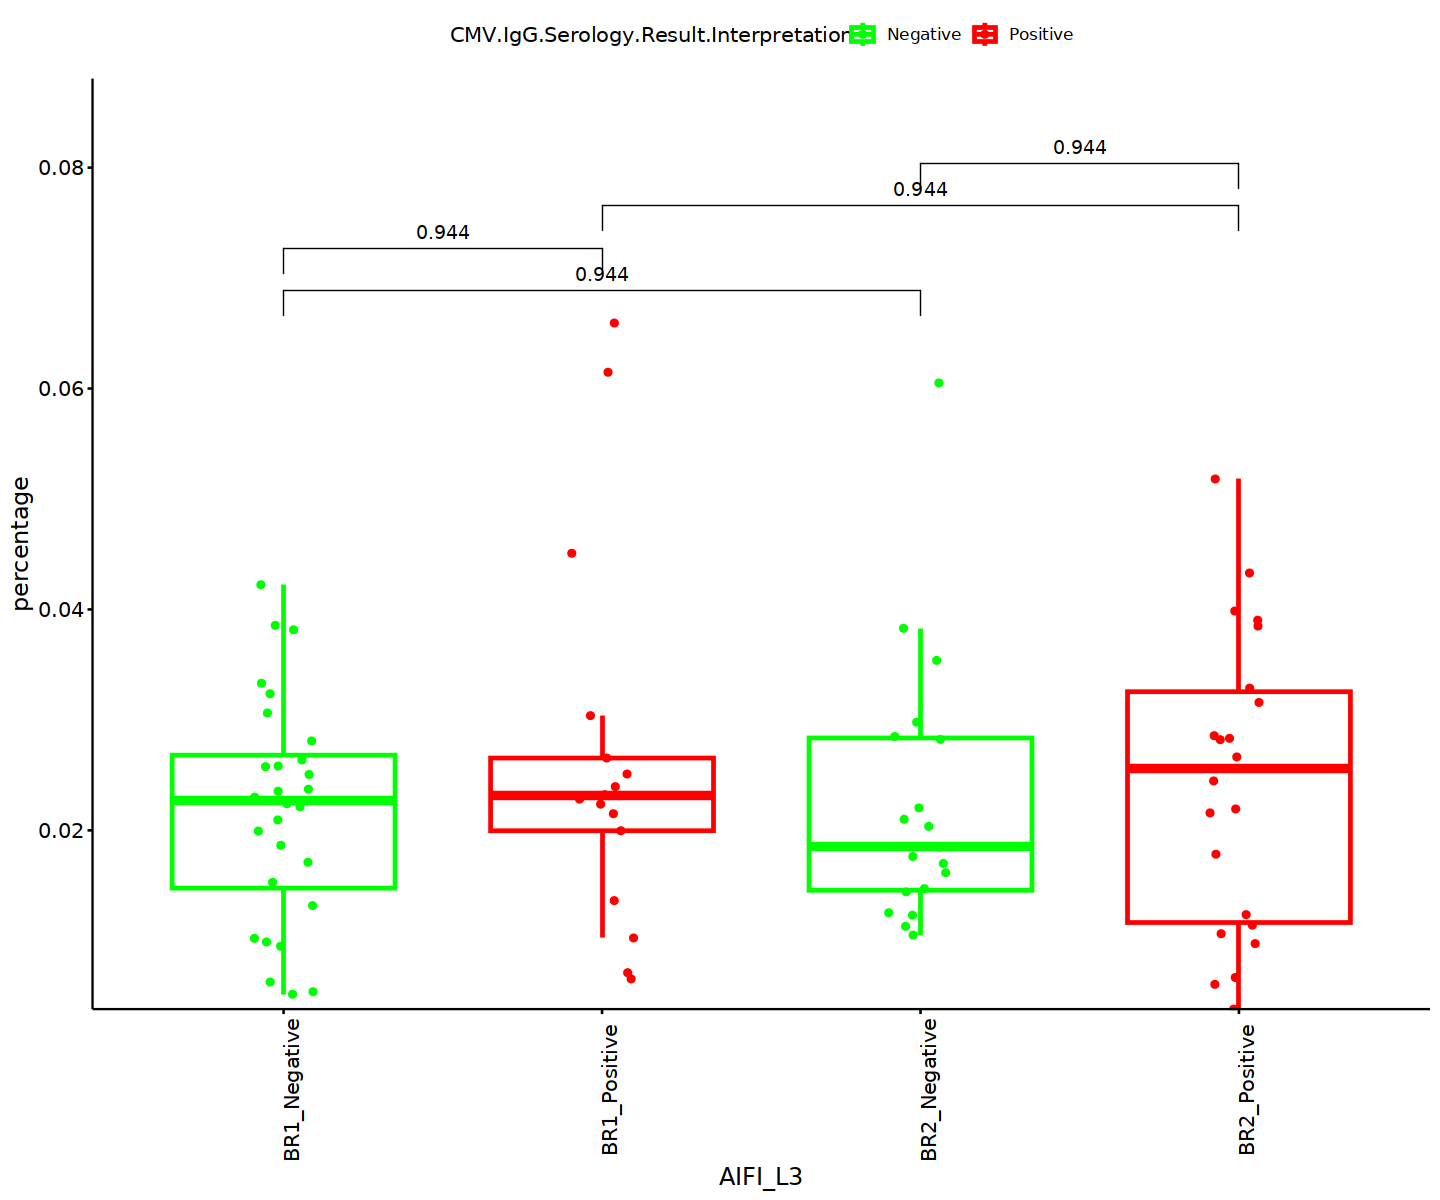

In [327]:
p2
stat_test

In [ ]:
# my_comparisons <- list( c("0.5", "1"), c("1", "2"), c("0.5", "2"))
# t_test_tooth <- compare_means(len ~ dose, comparisons = my_comparisons, p.adjust.method = "bonferroni", method='t.test', data = ToothGrowth)
# t_test_tooth <- t_test_tooth %>% mutate(y.position = c(29, 35, 39))
# ggboxplot(ToothGrowth, x = "dose" , y = "len") + stat_pvalue_manual(t_test_tooth, label = "p.adj")

# max_values<-result %>%
#   group_by(gdT_Subset,cohort.cohortGuid) %>%
#   slice(which.max(percentage_clr))%>% select(percentage_clr) %>% pull()+1
# stat.test$y.position<-max_values

# Final Loop code

In [246]:
#for CLR using ggpubr

my_comparisons <- list(c("BR1_Negative", "BR2_Negative"), c("BR1_Negative", "BR1_Positive"), c("BR1_Positive", "BR2_Positive"), c("BR2_Negative", "BR2_Positive") )

for(cell in result$AIFI_L3){
    print(cell)
    cell_df <- result %>% dplyr::filter(AIFI_L3 == cell)
    
    stat_test_loop <- wilcox_test(percentage ~ facet_combined, data = cell_df, comparisons = my_comparisons, paired= FALSE)
    %>%  adjust_pvalue(method = 'BH') %>% 
           add_xy_position(x = "facet_combined", dodge = 0.8)
    
    outfile <- paste("/home/jupyter/Myeloid_cells/Plots/Percentage_CLR_Comparisons_cohort_&_CMV/Percentage_Comparisons_cohort_&_CMV_", cell, ".pdf", sep="")
    
    p1 <- cell_df %>%
    ggpubr::ggboxplot(x = 'facet_combined', y = 'percentage', color = 'CMV.IgG.Serology.Result.Interpretation', add = "jitter", size = 1) +
    ylab('percentage') + 
    xlab(cell) +
    #scale_y_continuous(breaks = c(0.000, 0.025, 0.050, 0.075, 0.100)) +  # Set y-axis scale
    scale_color_manual(values = c("green", "red", "orange", "blue")) +
    #stat_compare_means(comparisons = my_comparisons, method = "wilcox.test", paired = FALSE) + 
    #stat_compare_means(label.y = 0.02)+
     theme(axis.text.x = element_text(size = 12),     # Adjust font size of x-axis text
        axis.text.y = element_text(size = 12),     # Adjust font size of y-axis text
        axis.title = element_text(size = 14))+
     stat_pvalue_manual(stat_test_loop, label = "p.adj.signif", tip.length =0) + #y.position = c(3, 3.5, 4 ,4.5))
    scale_y_continuous(expand = expansion(mult = c(0, 0.1)))
    pdf(file = outfile, width = 15, height = 7)
    print(p1)
    dev.off()
    
    }

[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "Activated memory B cell"
[1] "Activated memory B 

In [ ]:
##For CLR USE GGPLOt2

my_comparisons <- list(c("BR1_Negative", "BR2_Negative"), c("BR1_Negative", "BR1_Positive"), c("BR1_Positive", "BR2_Positive"), c("BR2_Negative", "BR2_Positive") )

for(cell in result$AIFI_L3){
    
    print(cell)
    cell_df <- result %>% dplyr::filter(AIFI_L3 == cell)
    
    stat_test <- wilcox_test(percentage_clr ~ facet_combined, data = cell_df, comparisons = my_comparisons, paired= FALSE)%>% 
           adjust_pvalue(method = 'BH') %>% 
           add_xy_position(x = "facet_combined", dodge = 0.8)
    
    outfile <- paste("/home/jupyter/Myeloid_cells/Plots/CLR_Comparisons_cohort_&_CMV/CLR_Comparisons_cohort_&_CMV_", cell, ".pdf", sep="")
    options(repr.plot.width = 18, repr.plot.height = 10)
    p3 <- ggplot(cell_df, aes(x = facet_combined, y = percentage_clr, color = CMV.IgG.Serology.Result.Interpretation)) +
      geom_boxplot(width = 0.5, outlier.shape = NA) +
      geom_jitter(width =0.1) +
      ylab('percentage_clr') + 
      xlab(cell) +
      scale_color_manual(values = c("green", "red", "orange", "blue")) +
      theme(axis.text.x = element_text(size = 12, angle = 90 ),     # Adjust font size of x-axis text
            axis.text.y = element_text(size = 12),     # Adjust font size of y-axis text
            axis.title = element_text(size = 14),
            panel.background = element_rect(fill = "white"),
            axis.line = element_line(color = "black"),  # Set axis line color to black,  # Set major grid line color to black
            panel.grid.minor = element_blank(),
            legend.position = "top",  # Set legend position to top
            #legend.title = element_blank()
           ) +
      geom_boxplot(position = position_dodge(width = 1))+
      stat_pvalue_manual(stat_test, label = "p.adj.signif", tip.length = 0) +
      scale_y_continuous(expand = expansion(mult = c(0, 0.1)))
      pdf(file = outfile, width = 7, height = 11)
      print(p3)
      dev.off()

    
    }





[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "Activated memory B cell"
[1] "Activated memory B 

In [241]:
stat_test_loop

.y.,group1,group2,n1,n2,statistic,p,p.adj,p.adj.signif
<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>
percentage_clr,BR1_Negative,BR2_Negative,29,21,362,0.265,0.3533333,ns
percentage_clr,BR1_Negative,BR1_Positive,29,18,382,0.007,0.0280000,*
percentage_clr,BR1_Positive,BR2_Positive,18,24,182,0.399,0.3990000,ns
percentage_clr,BR2_Negative,BR2_Positive,21,24,316,0.150,0.3000000,ns


In [332]:
unique(result$AIFI_L3)

[1] "ASDC"                                
 [2] "Activated memory B cell"             
 [3] "Adaptive NK cell"                    
 [4] "BaEoMaP cell"                        
 [5] "C1Q+ CD16 monocyte"                  
 [6] "CD14+ cDC2"                          
 [7] "CD27+ effector B cell"               
 [8] "CD27- effector B cell"               
 [9] "CD4 MAIT"                            
[10] "CD56bright NK cell"                  
[11] "CD8 MAIT"                            
[12] "CD8aa"                               
[13] "CD95 memory B cell"                  
[14] "CLP cell"                            
[15] "CM CD4 T cell"                       
[16] "CM CD8 T cell"                       
[17] "CMP cell"                            
[18] "Core CD14 monocyte"                  
[19] "Core CD16 monocyte"                  
[20] "Core memory B cell"                  
[21] "Core naive B cell"                   
[22] "Core naive CD4 T cell"               
[23] "Core naive CD8 T cell "              
[24] "DN T cell"                           
[25] "Early memory B cell"                 
[26] "Erythrocyte"                         
[27] "GZMB+ Vd2 gdT"                       
[28] "GZMB- CD27+ EM CD4 T cell"           
[29] "GZMB- CD27- EM CD4 T cell"           
[30] "GZMK+ CD27+ EM CD8 T cell"           
[31] "GZMK+ CD56dim NK cell"               
[32] "GZMK+ Vd2 gdT"                       
[33] "GZMK+ memory CD4 Treg"               
[34] "GZMK- CD27+ EM CD8 T cell"           
[35] "GZMK- CD56dim NK cell"               
[36] "HLA-DRhi cDC2"                       
[37] "IL1B+ CD14 monocyte"                 
[38] "ILC"                                 
[39] "ISG+ CD14 monocyte"                  
[40] "ISG+ CD16 monocyte"                  
[41] "ISG+ CD56dim NK cell"                
[42] "ISG+ MAIT"                           
[43] "ISG+ cDC2"                           
[44] "ISG+ memory CD4 T cell"              
[45] "ISG+ memory CD8 T cell"              
[46] "ISG+ naive B cell"                   
[47] "ISG+ naive CD4 T cell"               
[48] "ISG+ naive CD8 T cell"               
[49] "Intermediate monocyte"               
[50] "KLRB1+ memory CD4 Treg"              
[51] "KLRB1+ memory CD8 Treg"              
[52] "KLRF1+ GZMB+ CD27- EM CD8 T cell"    
[53] "KLRF1+ effector Vd1 gdT"             
[54] "KLRF1- GZMB+ CD27- EM CD8 T cell"    
[55] "KLRF1- GZMB+ CD27- memory CD4 T cell"
[56] "KLRF1- effector Vd1 gdT"             
[57] "Memory CD4 Treg"                     
[58] "Memory CD8 Treg"                     
[59] "Naive CD4 Treg"                      
[60] "Naive Vd1 gdT"                       
[61] "Plasma cell"                         
[62] "Platelet"                            
[63] "Proliferating NK cell"               
[64] "Proliferating T cell"                
[65] "SOX4+ Vd1 gdT"                       
[66] "SOX4+ naive CD4 T cell"              
[67] "SOX4+ naive CD8 T cell"              
[68] "Transitional B cell"                 
[69] "Type 2 polarized memory B cell"      
[70] "cDC1"                                
[71] "pDC"

In [337]:
##For percentage USE GGPUBR

my_comparisons <- list(c("BR1_Negative", "BR2_Negative"), c("BR1_Negative", "BR1_Positive"), c("BR1_Positive", "BR2_Positive"), c("BR2_Negative", "BR2_Positive") )

for(cell in result$AIFI_L3){
    
    print(cell)
    cell_df <- result %>% dplyr::filter(AIFI_L3 == cell)
    
        
    stat_test <- wilcox_test(percentage ~ facet_combined, data = cell_df, comparisons = my_comparisons, paired= FALSE)%>% 
           adjust_pvalue(method = 'BH') %>% 
           add_xy_position(x = "facet_combined", dodge = 0.8)
    #options(repr.plot.width = 18, repr.plot.height = 10)
    outfile <- paste("/home/jupyter/Myeloid_cells/Plots/Percentage_Comparisons_cohort_&_CMV/Percentage_Comparisons_cohort_&_CMV_", cell, ".pdf", sep="")
    p2 <- cell_df %>%
        ggpubr::ggboxplot(x = 'facet_combined', y = 'percentage', color = 'CMV.IgG.Serology.Result.Interpretation', add = "jitter", size = 1) +
        ylab('percentage') + 
        xlab(cell) +
        #scale_y_continuous(breaks = c(0.000, 0.025, 0.050, 0.075, 0.100)) +  # Set y-axis scale
        scale_color_manual(values = c("green", "red", "orange", "blue")) +
        #stat_compare_means(comparisons = my_comparisons, method = "wilcox.test", paired = FALSE) + 
        #stat_compare_means(label.y = 0.02)+
         theme(axis.text.x = element_text(size =8),     # Adjust font size of x-axis text
            axis.text.y = element_text(size = 8),     # Adjust font size of y-axis text
            axis.title = element_text(size = 8),
              legend.text = element_text(size = 8))+
        stat_pvalue_manual(stat_test, label = "p.adj.signif", tip.lenght =0)+   #, y.position = c(5, 5.5, 6 ,6.5))
        scale_y_continuous(expand = expansion(mult = c(0, 0.1)))
    
    ggpar(p2,legend = "right", legend.title = "CMV.IgG.Serology.Result.Interpretation",font.legend = c(8, "black"))
    pdf(file = outfile, width = 7, height = 11)
    print(p2)
    dev.off()

    
    }

[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "Activated memory B cell"
[1] "Activated memory B 

In [364]:
##For percentage USE GGPLOt2

my_comparisons <- list(c("BR1_Negative", "BR2_Negative"), c("BR1_Negative", "BR1_Positive"), c("BR1_Positive", "BR2_Positive"), c("BR2_Negative", "BR2_Positive") )

for(cell in result$AIFI_L3){
    
    print(cell)
    cell_df <- result %>% dplyr::filter(AIFI_L3 == cell)
    
    stat_test <- wilcox_test(percentage ~ facet_combined, data = cell_df, comparisons = my_comparisons, paired= FALSE)%>% 
           adjust_pvalue(method = 'BH') %>% 
           add_xy_position(x = "facet_combined", dodge = 0.8)
        
    outfile <- paste("/home/jupyter/Myeloid_cells/Plots/Percentage_Comparisons_cohort_&_CMV/Percentage_Comparisons_cohort_&_CMV_", cell, ".pdf", sep="")
    options(repr.plot.width = 18, repr.plot.height = 10)
    p3 <- ggplot(cell_df, aes(x = facet_combined, y = percentage, color = CMV.IgG.Serology.Result.Interpretation)) +
      geom_boxplot(width = 0.5, outlier.shape = NA) +
      geom_jitter(width =0.1) +
      ylab('percentage') + 
      xlab(cell) +
      scale_color_manual(values = c("green", "red", "orange", "blue")) +
      theme(axis.text.x = element_text(size = 12, angle = 90 ),     # Adjust font size of x-axis text
            axis.text.y = element_text(size = 12),     # Adjust font size of y-axis text
            axis.title = element_text(size = 14),
            panel.background = element_rect(fill = "white"),
            axis.line = element_line(color = "black"),  # Set axis line color to black,  # Set major grid line color to black
            panel.grid.minor = element_blank(),
            legend.position = "top",  # Set legend position to top
            #legend.title = element_blank()
           ) +
      geom_boxplot(position = position_dodge(width = 1))+
      stat_pvalue_manual(stat_test, label = "p.adj.signif", tip.length = 0) +
      scale_y_continuous(expand = expansion(mult = c(0, 0.1)))
      pdf(file = outfile, width = 7, height = 11)
      print(p3)
      dev.off()

    
    }





[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "ASDC"
[1] "Activated memory B cell"
[1] "Activated memory B 